# Riddler Classic - March 29, 2019

## Problem
_You are competing in a spelling bee alongside nine other contestants. You can each spell words perfectly from a certain portion of the dictionary but will misspell any word not in that portion of the book. Specifically, you have 99 percent of the dictionary down cold, and your opponents have 98 percent, 97 percent, 96 percent, and so on down to 90 percent memorized. The bee’s rules are simple: The contestants take turns spelling in some fixed order, which then restarts with the first surviving speller at the end of a round. Miss a word and you’re out, and the last speller standing wins. The bee words are chosen randomly from the dictionary._

_First, say the contestants go in decreasing order of their knowledge, so that you go first. What are your chances of winning the spelling bee? Second, say the contestants go in increasing order of knowledge, so that you go last. What are your chances of winning now?_

## Solution

### My Approach
Because I'm a peasant, I'm not very good at solving non-trivial statistics problems (like this one) analytically. My first thought is that some kind of Markov chain could be used but idk. Instead, I'm going to cheat and program a simple monte carlo model. Assuming the problem is modeled correctly, this should give me reasonably good approximate answers.

### The Code
First lets import a couple of handy packages

In [6]:
import random
from collections import deque, Counter, namedtuple
from matplotlib import pyplot as plt

The next section of code is going to look a little funny because...
1. I'm not a good programmer and
2. I tried to to implement the monte carlo model using object-oriented programming. Jupyter notebooks are not ideal for object-oriented code but I didn't feel much like changing my code. 

Below is a supporting class (that I shamelessly ripped off of Stack) that implements a cyclic list that elements can safely (at least I hope so) be removed from. It is supposed to represent the progression of contestants in the Spelling Bee (i.e. after the last person spells their word, we return to the first person that's still remaining). Ultimately the details here aren't very important.

In [7]:
class Modifiable_Cycle(object):
    def __init__(self, items=()):
        self.deque = deque(items)
        self.length = len(self.deque)
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if not self.deque:
            raise StopIteration
        item = self.deque.popleft()
        self.deque.append(item)
        return item
    
    next = __next__

    def delete_current(self):
        self.deque.pop()
        self.length -= 1
    
    def get_length(self):
        return self.length

Now let's get to the meet and potatoes. The following class implements the Spelling Bee competition as a class. The **compete** function runs through the competition once and **run_trials** function runs the **compete** function **num_trails** times and tracks the results.  

In [8]:
class Spelling_Bee(object):
    def __init__(self, players):
        """Create a Spelling Bee object

        Arguments:
        players -- a list of the players as named tuples
        """
        assert len(players) > 1, "One or more players must be in the Spelling Bee"
        self.players = players

    def compete(self):
        remaining_players = Modifiable_Cycle(self.players)
        for p in remaining_players:
            if remaining_players.get_length() == 1:
                return p
            elif random.random() > p.prob_correct:
                remaining_players.delete_current()
            else:
                continue

    def run_trials(self, num_trials):
        cnt = Counter()
        for t in range(num_trials):
            cnt[self.compete()] += 1
        return cnt

Now lets go ahead and use this class to run our monte carlo simulation and get some answers. Right now, the number of trials being run is 1000 simply because the results it produces are respresentative and don't take long to calculate.  Obviously more trials will help the solution converge.   
**Note:** In both the forward and reverse case, you (i.e. the player with a 99% chance of answering correctly) are player #1.  

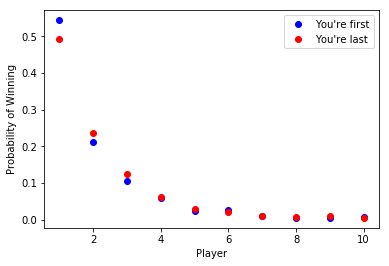

In [9]:
if __name__ == "__main__":
    
    Player = namedtuple('Player', ['name', 'prob_correct'])
    players = tuple(Player(i, (100-i)/100) for i in range(1,10+1))
    num_trials = 1000
    
    # Run the simulation with you (99% correct) starting
    sb = Spelling_Bee(players)
    results = sb.run_trials(num_trials)
    plot_data_x, plot_data_y = zip(*[(p[0].name, p[1]/num_trials) for p in results.items()])

    # Run the simulation with you (99% correct) last
    players_rev = tuple(reversed(players))
    sb = Spelling_Bee(players_rev)
    results_rev = sb.run_trials(num_trials)
    plot_data_x_rev, plot_data_y_rev = zip(*[(p[0].name, p[1]/num_trials) for p in results_rev.items()])
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(plot_data_x, plot_data_y, 'bo', label="You're first")
    ax.plot(plot_data_x_rev, plot_data_y_rev, 'ro', label="You're last")
    plt.legend(loc='upper right')
    plt.ylabel('Probability of Winning')
    plt.xlabel('Player')
    plt.show()

OK, looks like being the first vs. being the last doesn't make a big difference but going last does help a little bit.  I suspect this might be becuase all of the players have a relatively high chance of correctly answering.  If players were less likely to answer correctly, I think the ordering might matter more.  

Here's a print out of the results. Sorry they aren't in order. I didn't feel like ordering them :/  

In [10]:
    print("Case where you're starting:")
    print('\n'.join('  Player {0}: {1}'.format(p[0].name, p[1]/num_trials) for p in results.items()))

    print("Case where you're last:")
    print('\n'.join('  Player {0}: {1}'.format(p[0].name, p[1]/num_trials) for p in results_rev.items()))

Case where you're starting:
  Player 2: 0.212
  Player 1: 0.544
  Player 5: 0.025
  Player 6: 0.027
  Player 4: 0.06
  Player 3: 0.106
  Player 9: 0.005
  Player 7: 0.009
  Player 10: 0.007
  Player 8: 0.005
Case where you're last:
  Player 1: 0.492
  Player 2: 0.236
  Player 3: 0.124
  Player 4: 0.062
  Player 9: 0.011
  Player 8: 0.008
  Player 10: 0.006
  Player 6: 0.021
  Player 7: 0.011
  Player 5: 0.029


As always, there are a variety of ways to improve on this solution/code. Here are a few:
1. solve the problem analytically to veryify the results of the monte carlo simulation,
2. add some statistics to the results to see if the the order actually made a staticstically significant difference (error bars would be an easy next step),
3. I have not done much work parallelizing code but I suspect this simulation could easily be parallelize by running **x** number of trials on each node and then summing the results at the end.  
4. I have a feeling there may be a way to accelerate the progress of each trial while still maintaing the same results by lowering the probablity of each player answering correctly but maintaining the relative probability between the various players.  